In [1]:
from pydub import AudioSegment
from pydub.utils import mediainfo
from scipy import spatial
from glob import glob
from IPython.display import Audio
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import h5py
import datetime
%matplotlib inline

In [2]:
f = h5py.File("test.hdf5", "r")
list(f)

['10',
 '1039',
 '1040',
 '1066',
 '1069',
 '1073',
 '1075',
 '1082',
 '1083',
 '1087',
 '1102',
 '1193',
 '1195',
 '1196',
 '1197',
 '1249',
 '1259',
 '1270',
 '1276',
 '1277',
 '1278',
 '140',
 '141',
 '1417',
 '1427',
 '1443',
 '148',
 '1482',
 '1510',
 '1544',
 '1642',
 '1644',
 '1649',
 '1661',
 '1663',
 '1666',
 '1673',
 '1680',
 '1681',
 '1682',
 '1683',
 '1684',
 '1685',
 '1686',
 '1687',
 '1688',
 '1689',
 '1701',
 '1702',
 '1703',
 '1704',
 '1706',
 '1720',
 '1732',
 '1733',
 '1735',
 '1736',
 '182',
 '1883',
 '1891',
 '1893',
 '190',
 '1924',
 '1925',
 '1929',
 '193',
 '1930',
 '194',
 '197',
 '2',
 '200',
 '203',
 '204',
 '207',
 '210',
 '211',
 '212',
 '213',
 '255',
 '256',
 '368',
 '424',
 '459',
 '5',
 '534',
 '540',
 '546',
 '574',
 '602',
 '615',
 '620',
 '621',
 '625',
 '666',
 '667',
 '676',
 '690',
 '694',
 '695',
 '704',
 '705',
 '706',
 '707',
 '708',
 '709',
 '714',
 '715',
 '716',
 '718',
 '777',
 '814',
 '821',
 '822',
 '825',
 '853',
 '890',
 '892',
 '897',
 

In [14]:
templabel = '10'
NUM_FP = f[templabel].shape[0]
LENGTH = f[templabel].shape[1]
## PER_NUSIC * NUM_LABEL + NUM_POS >= k
PER_MUSIC = 5
NUM_LABEL = 48
NUM_POS = 16
NUM_MUSIC = len(f)

def get_batch(f, k=256, shuffle=True, actual_label=False):
    ##f: hdf5 file object
    
    # initialize array
    batch = []
    label = []

    # get the anchor label
    anchor = np.random.choice(NUM_MUSIC, 1)[0]
    
    # get different negative labels
    labels = np.random.choice(NUM_MUSIC, NUM_LABEL, replace=False)
    while np.any(labels == anchor):
        labels = np.random.choice(NUM_MUSIC, NUM_LABEL, replace=False)
    
    # get negative data
    for i in range(len(labels)):
        cur_label = list(f)[labels[i]]
        num_fp = f[cur_label].shape[0]
        rand = np.sort(np.random.choice(num_fp, PER_MUSIC, replace=False))
        val = f[cur_label][list(rand)]
        batch.append(val)
        
        if actual_label:
            label += [int(cur_label)] * PER_MUSIC
        else:
            label += list(np.arange(PER_MUSIC)+i*PER_MUSIC)

    batch = np.asarray(batch)
    batch = batch.reshape(PER_MUSIC*NUM_LABEL, LENGTH)
    
    # get positive data (consecutive segments within 400 ms)
    cur_label = list(f)[anchor]
    num_fp = f[cur_label].shape[0]
    start = np.random.choice(num_fp-NUM_POS, 1)[0] # get start point of the segments
    batch = list(f[cur_label][start:start+NUM_POS]) + list(batch)

    if actual_label:
        label += [int(cur_label)] * NUM_POS
    else:
        label += [0] * NUM_POS

    label = np.asarray(label)
    batch = np.asarray(batch)

    # shuffle all samples
    if shuffle:
        s = np.arange(batch.shape[0])
        np.random.shuffle(s)
        batch = batch[s]
        label = label[s]
    
    # create k-size batches
    batch = batch[:k]
    label = label[:k]
    batch = batch.reshape(k, LENGTH, 1)

    return np.asarray(batch), np.asarray(label)

In [15]:
start = datetime.datetime.now()
train_data, train_label = get_batch(f)
end = datetime.datetime.now()
print(train_label.shape)
print(end-start)

OSError: Can't read data (file read failed: time = Thu Aug  1 15:42:28 2019
, filename = 'test.hdf5', file descriptor = 41, errno = 5, error message = 'Input/output error', buf = 0x143751cd0, total read size = 264600, bytes this sub-read = 264600, bytes actually read = 18446744073709551615, offset = 15682353760)

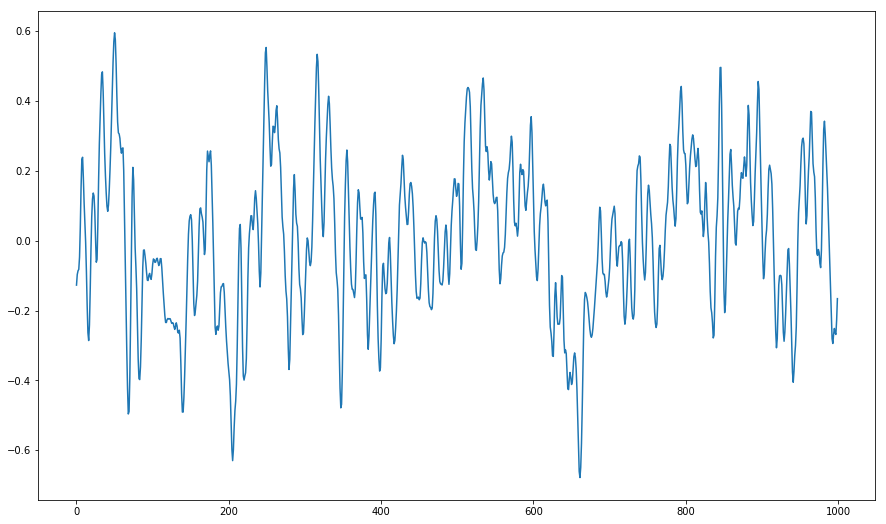

In [5]:
plt.figure(figsize=(15,9))
plt.plot(train_data[0][:1000])

In [6]:
MARGIN = 0.2

"""Define functions to create the triplet loss with online triplet mining."""

def _pairwise_distances(embeddings, squared=False):
    """Compute the 2D matrix of distances between all the embeddings.
    Args:
        embeddings: tensor of shape (batch_size, embed_dim)
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        pairwise_distances: tensor of shape (batch_size, batch_size)
    """
    # Get the dot product between all embeddings
    # shape (batch_size, batch_size)
    dot_product = tf.matmul(embeddings, tf.transpose(embeddings))

    # Get squared L2 norm for each embedding. We can just take the diagonal of `dot_product`.
    # This also provides more numerical stability (the diagonal of the result will be exactly 0).
    # shape (batch_size,)
    square_norm = tf.diag_part(dot_product)

    # Compute the pairwise distance matrix as we have:
    # ||a - b||^2 = ||a||^2  - 2 <a, b> + ||b||^2
    # shape (batch_size, batch_size)
    distances = tf.expand_dims(square_norm, 1) - 2.0 * dot_product + tf.expand_dims(square_norm, 0)

    # Because of computation errors, some distances might be negative so we put everything >= 0.0
    distances = tf.maximum(distances, 0.0)

    if not squared:
        # Because the gradient of sqrt is infinite when distances == 0.0 (ex: on the diagonal)
        # we need to add a small epsilon where distances == 0.0
        mask = tf.to_float(tf.equal(distances, 0.0))
        distances = distances + mask * 1e-16

        distances = tf.sqrt(distances)

        # Correct the epsilon added: set the distances on the mask to be exactly 0.0
        distances = distances * (1.0 - mask)

    return distances


def _get_anchor_positive_triplet_mask(labels):
    """Return a 2D mask where mask[a, p] is True iff a and p are distinct and have same label.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check that i and j are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)

    # Check if labels[i] == labels[j]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    # Combine the two masks
    mask = tf.logical_and(indices_not_equal, labels_equal)

    return mask


def _get_anchor_negative_triplet_mask(labels):
    """Return a 2D mask where mask[a, n] is True iff a and n have distinct labels.
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    Returns:
        mask: tf.bool `Tensor` with shape [batch_size, batch_size]
    """
    # Check if labels[i] != labels[k]
    # Uses broadcasting where the 1st argument has shape (1, batch_size) and the 2nd (batch_size, 1)
    labels_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))

    mask = tf.logical_not(labels_equal)

    return mask


def _get_triplet_mask(labels):
    """Return a 3D mask where mask[a, p, n] is True iff the triplet (a, p, n) is valid.
    A triplet (i, j, k) is valid if:
        - i, j, k are distinct
        - labels[i] == labels[j] and labels[i] != labels[k]
    Args:
        labels: tf.int32 `Tensor` with shape [batch_size]
    """
    # Check that i, j and k are distinct
    indices_equal = tf.cast(tf.eye(tf.shape(labels)[0]), tf.bool)
    indices_not_equal = tf.logical_not(indices_equal)
    i_not_equal_j = tf.expand_dims(indices_not_equal, 2)
    i_not_equal_k = tf.expand_dims(indices_not_equal, 1)
    j_not_equal_k = tf.expand_dims(indices_not_equal, 0)

    distinct_indices = tf.logical_and(tf.logical_and(i_not_equal_j, i_not_equal_k), j_not_equal_k)


    # Check if labels[i] == labels[j] and labels[i] != labels[k]
    label_equal = tf.equal(tf.expand_dims(labels, 0), tf.expand_dims(labels, 1))
    i_equal_j = tf.expand_dims(label_equal, 2)
    i_equal_k = tf.expand_dims(label_equal, 1)

    valid_labels = tf.logical_and(i_equal_j, tf.logical_not(i_equal_k))

    # Combine the two masks
    mask = tf.logical_and(distinct_indices, valid_labels)

    return mask


def batch_all_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    We generate all the valid triplets and average the loss over the positive ones.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # shape (batch_size, batch_size, 1)
    anchor_positive_dist = tf.expand_dims(pairwise_dist, 2)
    assert anchor_positive_dist.shape[2] == 1, "{}".format(anchor_positive_dist.shape)
    # shape (batch_size, 1, batch_size)
    anchor_negative_dist = tf.expand_dims(pairwise_dist, 1)
    assert anchor_negative_dist.shape[1] == 1, "{}".format(anchor_negative_dist.shape)

    # Compute a 3D tensor of size (batch_size, batch_size, batch_size)
    # triplet_loss[i, j, k] will contain the triplet loss of anchor=i, positive=j, negative=k
    # Uses broadcasting where the 1st argument has shape (batch_size, batch_size, 1)
    # and the 2nd (batch_size, 1, batch_size)
    triplet_loss = anchor_positive_dist - anchor_negative_dist + margin

    # Put to zero the invalid triplets
    # (where label(a) != label(p) or label(n) == label(a) or a == p)
    mask = _get_triplet_mask(labels)
    mask = tf.to_float(mask)
    triplet_loss = tf.multiply(mask, triplet_loss)

    # Remove negative losses (i.e. the easy triplets)
    triplet_loss = tf.maximum(triplet_loss, 0.0)

    # Count number of positive triplets (where triplet_loss > 0)
    valid_triplets = tf.to_float(tf.greater(triplet_loss, 1e-16))
    num_positive_triplets = tf.reduce_sum(valid_triplets)
    num_valid_triplets = tf.reduce_sum(mask)
    fraction_positive_triplets = num_positive_triplets / (num_valid_triplets + 1e-16)

    # Get final mean triplet loss over the positive valid triplets
    triplet_loss = tf.reduce_sum(triplet_loss) / (num_positive_triplets + 1e-16)

    return triplet_loss, fraction_positive_triplets


def batch_hard_triplet_loss(labels, embeddings, margin, squared=False):
    """Build the triplet loss over a batch of embeddings.
    For each anchor, we get the hardest positive and hardest negative to form a triplet.
    Args:
        labels: labels of the batch, of size (batch_size,)
        embeddings: tensor of shape (batch_size, embed_dim)
        margin: margin for triplet loss
        squared: Boolean. If true, output is the pairwise squared euclidean distance matrix.
                 If false, output is the pairwise euclidean distance matrix.
    Returns:
        triplet_loss: scalar tensor containing the triplet loss
    """
    # Get the pairwise distance matrix
    pairwise_dist = _pairwise_distances(embeddings, squared=squared)

    # For each anchor, get the hardest positive
    # First, we need to get a mask for every valid positive (they should have same label)
    mask_anchor_positive = _get_anchor_positive_triplet_mask(labels)
    mask_anchor_positive = tf.to_float(mask_anchor_positive)

    # We put to 0 any element where (a, p) is not valid (valid if a != p and label(a) == label(p))
    anchor_positive_dist = tf.multiply(mask_anchor_positive, pairwise_dist)

    # shape (batch_size, 1)
    hardest_positive_dist = tf.reduce_max(anchor_positive_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_positive_dist", tf.reduce_mean(hardest_positive_dist))

    # For each anchor, get the hardest negative
    # First, we need to get a mask for every valid negative (they should have different labels)
    mask_anchor_negative = _get_anchor_negative_triplet_mask(labels)
    mask_anchor_negative = tf.to_float(mask_anchor_negative)

    # We add the maximum value in each row to the invalid negatives (label(a) == label(n))
    max_anchor_negative_dist = tf.reduce_max(pairwise_dist, axis=1, keepdims=True)
    anchor_negative_dist = pairwise_dist + max_anchor_negative_dist * (1.0 - mask_anchor_negative)

    # shape (batch_size,)
    hardest_negative_dist = tf.reduce_min(anchor_negative_dist, axis=1, keepdims=True)
    tf.summary.scalar("hardest_negative_dist", tf.reduce_mean(hardest_negative_dist))

    # Combine biggest d(a, p) and smallest d(a, n) into final triplet loss
    triplet_loss = tf.maximum(hardest_positive_dist - hardest_negative_dist + margin, 0.0)

    # Get final mean triplet loss
    triplet_loss = tf.reduce_mean(triplet_loss)

    return triplet_loss

In [7]:
NUM_EMBEDDING = 64
SPLIT = 8

def model1(features):
    # convolution layer 1 
    conv1 = tf.layers.conv1d(
        inputs=features,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 1
    pool1 = tf.layers.max_pooling1d(inputs=conv1, pool_size=2, strides=2)
    
    # convolution layer 2 
    conv2 = tf.layers.conv1d(
        inputs=pool1,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 2
    pool2 = tf.layers.max_pooling1d(inputs=conv2, pool_size=2, strides=2)
    
    # convolution layer 3 
    conv3 = tf.layers.conv1d(
        inputs=pool2,
        filters=32,
        kernel_size=3,
        padding="same",
        activation=tf.nn.relu)
    
    # pooling layer 3
    pool3 = tf.layers.max_pooling1d(inputs=conv3, pool_size=2, strides=2)
    
    # flatten input: 16*64=1024
    flat = tf.layers.flatten(pool3)
    
    drop = tf.layers.dropout(flat)

    # divide and encode
    concatenate = []
    num_each_split = drop.shape[-1]//SPLIT
    units = NUM_EMBEDDING//SPLIT
    splits = tf.split(drop, SPLIT, 1)

    divides = []
    for i in range(SPLIT):
        divide = tf.layers.dense(splits[i], activation=tf.nn.relu, units=128)
        divide = tf.layers.dense(divide, units=units)
        concatenate.append(divide)
        divides.append(divide)
    
    raw = tf.concat([elem for elem in concatenate], 1)
    embedding = tf.math.l2_normalize(raw)

    return embedding

In [8]:
NUM_EMBEDDING = 64
NUM_LAYERS = 6

def model2(features):
    pool = []
    
    for i in range(NUM_LAYERS):
        if len(pool) == 0:
            inputs = features
        else:
            inputs = pool[-1]
            
        # convolution layers
        conv = tf.layers.conv1d(
            inputs=inputs,
            filters=32,
            kernel_size=3,
            padding="same",
            activation=tf.nn.relu)

        # pooling layers
        pool.append(tf.layers.max_pooling1d(inputs=conv, pool_size=2, strides=2))
        print(pool[-1])
    
    flat = tf.layers.flatten(pool[-1])
    print(flat)
    dense1 = tf.layers.dense(flat, activation=tf.nn.relu, units=1024)
    dense2 = tf.layers.dense(dense1, activation=tf.nn.relu, units=128)
    embedding = tf.layers.dense(dense1, units=NUM_EMBEDDING)
    
    return embedding

In [9]:
NUM_EMBEDDING = 64
dilation_rates = [2**i for i in range(8)]*2
receptive_field = sum(dilation_rates)+2

def WaveNet(x):
    print(x)
    x = tf.layers.conv1d(
        inputs=x,
        filters=16,
        kernel_size=2,
        padding="causal",
        activation=tf.nn.relu)
    
    skips = []
    
    for dilation_rate in dilation_rates:
        x = tf.layers.conv1d(
            inputs=x,
            filters=16,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
        
        x_f = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.tanh)
        
        x_g = tf.layers.conv1d(
            inputs=x,
            filters=32,
            kernel_size=2,
            padding="causal",
            dilation_rate=dilation_rate,
            activation=tf.nn.sigmoid)
        
        z = tf.multiply(x_f,x_g)
        
        skip = tf.layers.conv1d(
            inputs=z,
            filters=64,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
        
        z = tf.layers.conv1d(
            inputs=z,
            filters=16,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
        
        x = tf.add(x,z)
        
        skips.append(skip)
        
    out = tf.add_n(skips)
    out = tf.nn.relu(out)
    out = tf.layers.conv1d(
            inputs=out,
            filters=128,
            kernel_size=1,
            padding="same",
            activation=tf.nn.relu)
    out = tf.layers.dropout(
            inputs=out,
            rate=0.2)
    out = tf.layers.conv1d(
            inputs=out,
            filters=1,
            kernel_size=1,
            padding="same")
    out = tf.layers.flatten(out)
    out = tf.slice(out, [0,66150-NUM_EMBEDDING], [-1,NUM_EMBEDDING])
    print(out)
    
    return out

In [10]:
tf.reset_default_graph()

input_data = tf.placeholder(tf.float32, [None, LENGTH, 1])
input_label = tf.placeholder(tf.int32, [None])

# loss function operations
embedded = WaveNet(input_data)
#embedded = tf.debugging.check_numerics(embedded, 'embedded data has nan!')
loss, _dis = batch_all_triplet_loss(input_label, embedded, MARGIN, squared=True)
#loss = tf.reduce_mean(triplet_l)

# train operation
optimizer = tf.train.AdamOptimizer(learning_rate=0.001)
#variables = tf.trainable_variables()
#gradients = optimizer.compute_gradients(loss, variables)
train_op = optimizer.minimize(
    loss=loss,
    global_step=tf.train.get_global_step())
init = tf.global_variables_initializer()

Tensor("Placeholder:0", shape=(?, 66150, 1), dtype=float32)
Instructions for updating:
Use keras.layers.conv1d instead.
Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use keras.layers.dropout instead.
Instructions for updating:
Use keras.layers.flatten instead.
Tensor("Slice:0", shape=(?, 64), dtype=float32)
Instructions for updating:
Use tf.cast instead.


In [11]:
#del sess

In [12]:
saver = tf.train.Saver()
sess = tf.Session(config=tf.ConfigProto(log_device_placement=True))
sess.run(init)
loss_hist = []
#saver.restore(sess, "../model/model1.ckpt")

In [13]:
num_epoch = 1500
start = datetime.datetime.now()
for i in range(num_epoch):
    train_data, train_label = get_batch(f)
    _, loss_val, embedding = sess.run([train_op, loss, embedded],
                           feed_dict={input_data: train_data,
                                      input_label: train_label})
    loss_hist.append(loss_val)
    print(embedding)
    if i % 100 == 0:
        print('iter num: '+str(i)+' loss: '+str(loss_hist[-1]))
end = datetime.datetime.now()
print('time: '+str(end-start))

OSError: Can't read data (file read failed: time = Thu Aug  1 15:40:22 2019
, filename = 'test.hdf5', file descriptor = 41, errno = 5, error message = 'Input/output error', buf = 0x14360ecd0, total read size = 264600, bytes this sub-read = 264600, bytes actually read = 18446744073709551615, offset = 5059960136)

In [ ]:
# saver = tf.train.Saver()
save_path = saver.save(sess, "../model/WaveNet.ckpt")
print("Model saved in path: %s" % save_path)

In [ ]:
train_data, train_label = get_batch(f)
embeddings = sess.run([embedded], feed_dict={input_data: train_data})
print('first five embeddings: '+str(embeddings[0][:2]))
print('\nfirst ten labels: '+str(train_label))
plt.figure(figsize=(15,9))
plt.plot(loss_hist)
plt.title('loss history')

In [ ]:
tvars = tf.trainable_variables()
tvars_vals = sess.run(tvars)
for var, val in zip(tvars, tvars_vals):
    print(var.name, val) 
    
#tvars = tf.trainable_variables()
#for var, grads in zip(tvars, grad):
#    print(var.name, grads) 

In [ ]:
#tf.test.is_gpu_available()

In [ ]:
PER_TRACK = 570
database = []
datalabel = []
labels = list(f)
for i in range(len(labels)):
    db = f[labels[i]][:PER_TRACK]
    if db.shape[0] < PER_TRACK:
        db = list(db) + list(np.zeros([PER_TRACK-db.shape[0], 66150]))
        db = np.asarray(db)
    db = db.reshape(PER_TRACK, 66150, 1)
    tempbase = sess.run([embedded], feed_dict={input_data: db})[0]
    database.append(tempbase)
    templ = [labels[i]]*PER_TRACK
    tempdata = np.arange(PER_TRACK*50, step=50) # 50 represents 50 milliseconds
    datalabel.append(list(zip(templ, tempdata)))
    
database = np.asarray(database).reshape(len(labels)*PER_TRACK, 64)
datalabel = np.asarray(datalabel).reshape(len(labels)*PER_TRACK, 2)
print(database.shape)
print(datalabel.shape)


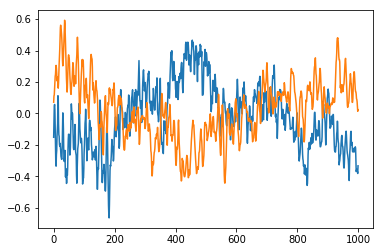

In [14]:
Fs = 44100
data_path = '../fma_small/000/000010.mp3'
test_path = 'test_songs/freeway.mp3'
#print(mediainfo(data_path)['TAG']['title'])
datamusic = AudioSegment.from_file(data_path)
testmusic = AudioSegment.from_file(test_path)
data = np.array(datamusic.get_array_of_samples())
test = np.array(testmusic.get_array_of_samples())
data = [data[i] for i in range(0,len(data),2)]
test = [test[i] for i in range(0,len(test),2)]
data = data[:15*Fs]
test = test[Fs*65:Fs*80]
data = data/np.amax(data)
test = test/np.amax(test)
plt.plot(test[10500:11500])
plt.plot(data[10500:11500])

In [15]:
Audio(data=data, rate=Fs)

In [16]:
Audio(data=test, rate=Fs)

In [17]:
threshold = 100 # threshold to get the similarity
def similarity(query, embeds):
    distance = [spatial.distance.cosine(ref, query) for ref in embeds]
    sim = 1 - threshold * np.asarray(distance)
    return sim

LENGTH = int(1.5*Fs)
INPUT_LEN = 30*Fs
INTERVAL = int(0.05*Fs) #in seconds, determines how many fingerprints each song will generate
TEST_NUM = 10
TEST_K = 10

test_path = 'test_songs/freeway.mp3'
music = AudioSegment.from_file(data_path)
test = np.array(music.get_array_of_samples())
# check if the audio has two channels
if len(test) > INPUT_LEN: 
    test = [test[i] for i in range(0,len(test),2)] #get left channel only
#test = test[Fs*65:Fs*95]
offset = 10

# take consecutive 10 segments
test_data = []
for i in range(TEST_NUM):
    #segment = test[i*LENGTH:(i+1)*LENGTH]
    segment = test[(i+offset)*LENGTH//2:(i+offset)*LENGTH//2+LENGTH]
    segment = np.asarray(segment)          
    test_data.append(segment)

test_data = np.asarray(test_data)
test_data = test_data.astype(np.float32)
test_data = test_data/np.amax(test_data)
test_data = test_data.reshape(TEST_NUM, 66150, 1)
test_data[0]

array([[ 0.14471877],
       [ 0.05783258],
       [-0.00326548],
       ...,
       [-0.06161687],
       [-0.06942961],
       [-0.07275613]], dtype=float32)

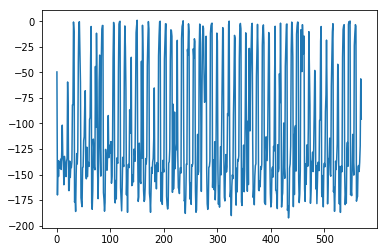

In [18]:
test_embed = sess.run([embedded], feed_dict={input_data: test_data})[0]
datain = f['10'][...].reshape(570, 66150, 1)
datab = sess.run([embedded], feed_dict={input_data: datain})[0]
plt.plot(similarity(test_embed[0], datab))

In [35]:
LENGTH = int(1.5*Fs)
INPUT_LEN = 30*Fs
INTERVAL = int(0.05*Fs) #in seconds, determines how many fingerprints each song will generate
TEST_NUM = 10
TEST_K = 10

test_path = 'test_songs/hwy.mp3'
music = AudioSegment.from_file(test_path)
test = np.array(music.get_array_of_samples())
# check if the audio has two channels
if len(test) > INPUT_LEN: 
    test = [test[i] for i in range(0,len(test),2)] #get left channel only
start = 112
test = test[Fs*start:Fs*(start+30)]
offset = 5

# take consecutive 10 segments
test_data = []
for i in range(TEST_NUM):
    #segment = test[i*LENGTH:(i+1)*LENGTH]
    segment = test[(i+offset)*LENGTH//2:(i+offset)*LENGTH//2+LENGTH]
    segment = np.asarray(segment)          
    test_data.append(segment)

test_data = np.asarray(test_data)
test_data = test_data.astype(np.float32)
test_data = test_data/np.amax(test_data)
test_data = test_data.reshape(TEST_NUM, 66150, 1)
#test_data = test_data + (np.random.rand(TEST_NUM, 66150, 1)-0.5)/50

test_embed = sess.run([embedded], feed_dict={input_data: test_data})[0]

threshold = 100 # threshold to get the similarity
def similarity(query, embeds):
    distance = [spatial.distance.cosine(ref, query) for ref in embeds]
    sim = 1 - threshold * np.asarray(distance)
    return sim

simvec = []
for i in range(TEST_NUM):
    mostsims = similarity(test_embed[i], database)
    mostsims = np.argsort(-mostsims)[:TEST_K]
    mostsims = np.sort(mostsims)
    simvec.append(mostsims)

simvec = np.asarray(simvec)
simvec

array([[36104, 46204, 46283, 46284, 46364, 46444, 46523, 46524, 46604,
        46684],
       [13537, 21040, 21772, 22256, 22257, 41302, 44835, 47897, 50420,
        50579],
       [ 9943, 14740, 17881, 23615, 30253, 30361, 51711, 54404, 54461,
        67491],
       [ 9193,  9548,  9957, 30666, 34784, 36067, 36344, 39059, 54201,
        54738],
       [ 4334,  7167,  7603, 10757, 15615, 23699, 51576, 54310, 63902,
        64062],
       [ 4446,  4867,  9833, 17879, 30723, 42395, 56288, 63897, 63916,
        64057],
       [11468, 12901, 23657, 25281, 26635, 34798, 40354, 45911, 59493,
        63930],
       [ 1641,  2851,  3014,  9979, 16990, 27723, 32730, 57527, 67446,
        67602],
       [30693, 47564, 47565, 47612, 47613, 47660, 47757, 47851, 56172,
        63936],
       [ 7420,  8085,  8124,  8239,  8241,  9285, 23623, 40349, 42479,
        51919]])

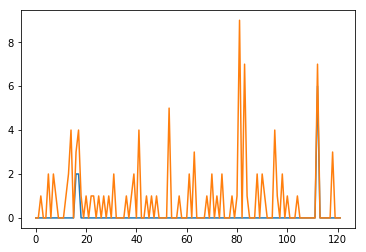

In [44]:
DIFF = 15
TOL = 2
vals = []
for i in range(1,TEST_NUM):    
    for j in range(TEST_NUM-i):
        all_diff = np.expand_dims(simvec[j+i], axis=1) - np.expand_dims(simvec[j], axis=0) 
        prev, curr = np.where((all_diff >= DIFF*i-TOL) & (all_diff <= DIFF*i+TOL))
        #print(str(i)+' diffs: '+str(prev)+' '+str(curr))
        for pre in prev:
            vals.append(simvec[j+i][pre])
        for cur in curr:
            vals.append(simvec[j][cur])

vals = np.asarray(vals)
accu = []
brut = []
for i in range(len(f)):
    accu.append(vals[(vals > i*570) & (vals < (i+1)*570)].shape[0])
    brut.append(simvec[(simvec > i*570) & (simvec < (i+1)*570)].shape[0])
plt.plot(accu)
plt.plot(brut)

In [41]:
datalabel[65*570]

array(['193', '0'], dtype='<U5')